# TextCNN on NLP

Traditionally, for Natural Language Processing (NLP), we used recurrent neural networks (RNN) to process the text data. In fact, we can also treat text as a one-dimensional image, so that we can use one-dimensional convolutional neural networks (CNN) to capture associations between adjacent words. 

![A one-dimensional word vectors.](https://nbviewer.jupyter.org/format/slides/github/goldmermaid/gtc2020/blob/master/Notebooks/1d-vector.svg)

This notebook describes a groundbreaking approach to applying convolutional neural networks to text analysis: textCNN [by Kim et al.](https://arxiv.org/abs/1408.5882). 

First, import the environment packages and modules.

In [1]:
import d2l
from mxnet import gluon, init, np, npx
from mxnet.contrib import text
from mxnet.gluon import nn
npx.set_np()

## The Dataset

Here we use Stanford’s [Large Movie Review Dataset](https://ai.stanford.edu/~amaas/data/sentiment/) as the dataset for sentiment analysis. 

The training and testing dataset each contains 25,000 movie reviews downloaded from IMDb, respectively. In addition, the number of comments labeled as “positive” and “negative” is equal in each dataset.



For the purpose of simplicity, we are using a built-in function `load_data_imdb` in the d2l package to load the dataset. If you are interested in the preprocessing of the full dataset, please check [more detail](https://d2l.ai/chapter_natural-language-processing/sentiment-analysis.html) at D2L.ai.

In [2]:
batch_size = 64
train_iter, test_iter, vocab = d2l.load_data_imdb(batch_size)

for X_batch, y_batch in train_iter:
    print("\n X_batch has shape {}, and y_batch has shape {}".format(X_batch.shape, y_batch.shape))
    break


 X_batch has shape (64, 500), and y_batch has shape (64,)


## The TextCNN Model's Skeleton

![An example to illustrate the textCNN.](https://d2l.ai/_images/textcnn.svg)

TextCNN involves the following steps:

1. Performing multiple **one-dimensional convolution** kernels on the input text sequences;
2. Applying **max-over-time pooling** on the previous output channels, and then concatenate to one vector;
3. Using the **fully connected layer** (aka. dense layer) and **dropout** on the previous outputs.


### 1. One-Dimensional Convolutional Layer

Like a two-dimensional convolutional layer, a one-dimensional convolutional layer uses a one-dimensional cross-correlation operation. 

In the one-dimensional cross-correlation operation, the convolution window slides on the input array from left to right successively. 

At a certain position, the input array in the convolution window and kernel array are elementwise multiplied and summed to obtain the output array. 

![One-dimensional cross-correlation operation.](https://raw.githubusercontent.com/d2l-ai/d2l-en/master/img/conv1d.svg?sanitize=true)

Now let's implement one-dimensional cross-correlation in the `corr1d` function. It accepts the input array X and kernel array K, then it outputs the array Y.

In [3]:
def corr1d(X, K):
    w = K.shape[0]
    Y = np.zeros((X.shape[0] - w + 1))
    for i in range(Y.shape[0]):
        Y[i] = (X[i: i + w] * K).sum()
    return Y

As shown in figure below, the input is a one-dimensional array with a width of 7 and the width of the kernel array is 2. As we can see, the output width is  $7−2+1=6$  and the first element is obtained by performing multiplication by element on the leftmost input subarray with a width of 2 and kernel array and then summing the results.

![One-dimensional cross-correlation operation.](https://raw.githubusercontent.com/d2l-ai/d2l-en/master/img/conv1d.svg?sanitize=true)

In [4]:
X, K = np.array([0, 1, 2, 3, 4, 5, 6]), np.array([1, 2])
corr1d(X, K)

array([ 2.,  5.,  8., 11., 14., 17.])

We can use the [gluon built-in class `Conv1D()`](https://beta.mxnet.io/api/gluon/_autogen/mxnet.gluon.nn.Conv1D.html) to perform the 1D convolution. 

To use `Conv1D()`, we need to firstly define a new `Sequential()` architecture, "convs", which can stack neural network layers sequentially. 

In [5]:
num_channels, kernel_sizes = 2, 4

convs = nn.Sequential()
convs.add(nn.Conv1D(num_channels, kernel_sizes, activation='relu'))

Then, we randomly initialize its weights with a normal distribution (zero mean and 0.01 standard deviation) through the `initialize()` function.

In [6]:
convs.initialize(init.Normal(sigma=0.01))
convs

Sequential(
  (0): Conv1D(-1 -> 2, kernel_size=(4,), stride=(1,), Activation(relu))
)

Note that the required inputs of `Conv1D()` is an 3D input tensor with shape `(batch_size, in_channels, width)`. In the context of NLP, this shape can be interpreted as `(batch_size, word_vector_dimension, number_of_words)`.

### 2. Max-Over-Time Pooling Layer

In textCNN, the max-over-time pooling layer equals to a one-dimensional global maximum pooling layer. 

We can use the [gluon built-in class `GlobalMaxPool1D()`](https://beta.mxnet.io/api/gluon/_autogen/mxnet.gluon.nn.GlobalAvgPool1D.html) as below:

```python
            max_over_time_pooling = nn.GlobalMaxPool1D()
```

![The max-over-time pooling layer.](https://nbviewer.jupyter.org/format/slides/github/goldmermaid/gtc2020/blob/master/Notebooks/maxpooling.svg)

### 3. Fully Connected Layer and Dropout 

The fully connected layer is referred as the `Dense()` layer in Gluon ([more detail](https://d2l.ai/chapter_multilayer-perceptrons/mlp-gluon.html) in D2L). 

Besides, a dropout layer `Dropout()` can be used after the fully connected layer to deal with the overfitting problem.

![The fully connected layer.](https://nbviewer.jupyter.org/format/slides/github/goldmermaid/gtc2020/blob/master/Notebooks/ff.svg)

In [7]:
decoder = nn.Dense(2)  # 2 outputs
print("Shape of Dense : ", decoder)

dropout = nn.Dropout(0.4)  # dropout 40% of neurons' weights
print("Shape of Dropout : ", decoder)

Shape of Dense :  Dense(-1 -> 10, linear)
Shape of Dropout :  Dense(-1 -> 10, linear)


## The TextCNN Model 

Now let's put everything together!

Suppose that:

- the input text sequence consists of $n$ words;
- each word is represented by a $d$-dimension word vector;

Then the input example has a width of $n$, a height of 1, and $d$ input channels. 

### Model Initialization

We first initialize the layers of our `textCNN` class.

```python
class TextCNN(nn.Block):
    def __init__(self, vocab_size, embed_size, kernel_sizes, num_channels,
                 **kwargs):
        super(TextCNN, self).__init__(**kwargs)
        self.embedding = nn.Embedding(vocab_size, embed_size)
        # The constant embedding layer does not participate in training
        self.constant_embedding = nn.Embedding(vocab_size, embed_size)
        self.dropout = nn.Dropout(0.5)
        self.decoder = nn.Dense(2)
        # The max-over-time pooling layer has no weight, so it can share an
        # instance
        self.pool = nn.GlobalMaxPool1D()
        # Create multiple one-dimensional convolutional layers
        self.convs = nn.Sequential()
        for c, k in zip(num_channels, kernel_sizes):
            self.convs.add(nn.Conv1D(c, k, activation='relu'))
```

### The `forward` Function
Now let's write the `forward` function of our `textCNN` class.

```python
def forward(self, inputs):
    embeddings = np.concatenate((
        self.embedding(inputs), self.constant_embedding(inputs)), 
        axis=2)
    embeddings = embeddings.transpose(0, 2, 1)
    encoding = np.concatenate([
        np.squeeze(self.pool(conv(embeddings)), axis=-1)
        for conv in self.convs], axis=1)
    outputs = self.decoder(self.dropout(encoding))
    return outputs
```

It looks a bit complicated, but we can decompose it to 4 steps.

#### Concatenation

First, we concatenate the output of two embedding layers with shape of `(batch_size, number_of_words, word_vector_dimension)` by the last dimension as below:

```python
    embeddings = np.concatenate((
        self.embedding(inputs), self.constant_embedding(inputs)), axis=2)
```

#### Transposing

Second, recall that the required inputs of `Conv1D()` is an 3D input tensor with shape `(batch_size, word_vector_dimension, number_of_words)`, while our current embeddings is of shape `(batch_size, number_of_words, word_vector_dimension)`. Hence, we need to transpose the last two dimensions as below:

```python
        embeddings = embeddings.transpose(0, 2, 1)
```

#### Encoding

Third, we compute `encoding` as below:

```python
    encoding = np.concatenate([np.squeeze(self.pool(conv(embeddings)), axis=-1)
                           for conv in self.convs], axis=1)
```

1. For each one-dimensional convolutional layer, we apply a max-over-time pooling, i.e., `self.pool()`. 
2. Since the max-over-time pooling is applied at the last dimension of convolution's outputs, the last dimension (axis = -1) will be 1. We use the flatten function `squeeze()` to remove it. 
3. We concatenate the results from varied convolution kernels (axis = 1) by `concatenate()`.

#### Decoding

Last, we apply the dropout function to randomly dropout some units of the encoding to avoid overfitting (i.e. not rely on one specific unit of encoding too much). And then we apply a fully connected layer as a decoder to obtain the outputs.

```python
        outputs = self.decoder(self.dropout(encoding))
```

To sum up, here is the full `TextCNN` class:

In [8]:
class TextCNN(nn.Block):
    def __init__(self, vocab_size, embed_size, kernel_sizes, num_channels,
                 **kwargs):
        super(TextCNN, self).__init__(**kwargs)
        self.embedding = nn.Embedding(vocab_size, embed_size)
        # The constant embedding layer does not participate in training
        self.constant_embedding = nn.Embedding(vocab_size, embed_size)
        self.dropout = nn.Dropout(0.5)
        self.decoder = nn.Dense(2)
        # The max-over-time pooling layer has no weight, so it can share 
        # an instance
        self.pool = nn.GlobalMaxPool1D()
        # Create multiple one-dimensional convolutional layers with
        # different kernel sizes and number of channels
        self.convs = nn.Sequential()
        for c, k in zip(num_channels, kernel_sizes):
            self.convs.add(nn.Conv1D(c, k, activation='relu'))
    def forward(self, inputs):
        embeddings = np.concatenate((
            self.embedding(inputs), self.constant_embedding(inputs)), axis=2)
        embeddings = embeddings.transpose(0, 2, 1)
        encoding = np.concatenate([np.squeeze(self.pool(conv(embeddings)), 
                                              axis=-1) 
                                   for conv in self.convs], axis=1)
        outputs = self.decoder(self.dropout(encoding))
        return outputs

### Load Pre-trained Embedding

Rather than training from scratch, we load a pre-trained 100-dimensional [GloVe word vectors](https://d2l.ai/chapter_natural-language-processing/glove.html). This step will take several minutes to load.

In [9]:
# Load word vectors and query the word vectors that in our vocabulary
glove_embedding = text.embedding.create(
    'glove', pretrained_file_name='glove.6B.100d.txt')
embeds = glove_embedding.get_vecs_by_tokens(vocab.idx_to_token)
print("embeds.shape : ", embeds.shape)

embeds.shape :  (49339, 100)


### Training

Now let's create a `TextCNN` model. Since multiple kernel filters (with varying window sizes) can obtain different features, the original `TextCNN` model applies 3 convolutional layers with kernel widths of 3, 4, and 5, respectively. 

Also, each of the filter window has an output channel with 100 units.

In [10]:
embed_size, kernel_sizes, nums_channels = 100, [3, 4, 5], [100, 100, 100]
ctx = d2l.try_all_gpus()  ## Get the GPUs
net = TextCNN(vocab_size=len(vocab), embed_size=embed_size, 
              kernel_sizes=kernel_sizes, num_channels=nums_channels)
net.initialize(init.Xavier(), ctx=ctx)
net

TextCNN(
  (embedding): Embedding(49339 -> 100, float32)
  (constant_embedding): Embedding(49339 -> 100, float32)
  (dropout): Dropout(p = 0.5, axes=())
  (decoder): Dense(-1 -> 2, linear)
  (pool): GlobalMaxPool1D(size=(1,), stride=(1,), padding=(0,), ceil_mode=True, global_pool=True, pool_type=max, layout=NCW)
  (convs): Sequential(
    (0): Conv1D(-1 -> 100, kernel_size=(3,), stride=(1,), Activation(relu))
    (1): Conv1D(-1 -> 100, kernel_size=(4,), stride=(1,), Activation(relu))
    (2): Conv1D(-1 -> 100, kernel_size=(5,), stride=(1,), Activation(relu))
  )
)

Then we initialize the embedding layers embedding and constant_embedding using the GloVe embeddings. Here, the former participates in training while the latter has a fixed weight.

In [11]:
net.embedding.weight.set_data(embeds)
net.constant_embedding.weight.set_data(embeds)
net.constant_embedding.collect_params().setattr('grad_req', 'null')

To train our `TextCNN` model, we also need to define:
1. the learning rate `lr`, 
2. the number of epochs `num_epochs`, 
3. the optimizer `adam`, 
4. the loss function `SoftmaxCrossEntropyLoss()`. 


For simplicity, we call the built-in function `train_ch13` ([more detail in D2L](https://d2l.ai/chapter_computer-vision/image-augmentation.html?highlight=train_ch13#using-an-image-augmentation-training-model)) to train.

loss 0.093, train acc 0.968, test acc 0.868
2887.2 examples/sec on [gpu(0), gpu(1), gpu(2), gpu(3)]


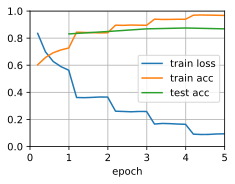

In [12]:
lr, num_epochs = 0.001, 5
trainer = gluon.Trainer(net.collect_params(), 'adam', {'learning_rate': lr})
loss = gluon.loss.SoftmaxCELoss()
d2l.train_ch13(net, train_iter, test_iter, loss, trainer, num_epochs, ctx)

Now is the time to use our trained model to classify sentiments of two simple sentences.

In [13]:
d2l.predict_sentiment(net, vocab, 'this movie is so amazing!')

'positive'